In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import copy
from EVFleet import * 
import pandas as pd

In [36]:
def create_energy_set(start, M, H, pv, wt):
    days = 365 // M -1
    q = np.zeros((M, H))
    Q = np.zeros((M, days * 24))
    for m in range(M):
        start_idx = m * days * 24
        end_idx = (m + 1) * days * 24
        Q[m, :] = pv[start_idx:end_idx] + wt[start_idx:end_idx]
        q[m, :] = Q[m, start:start+H]

    return q

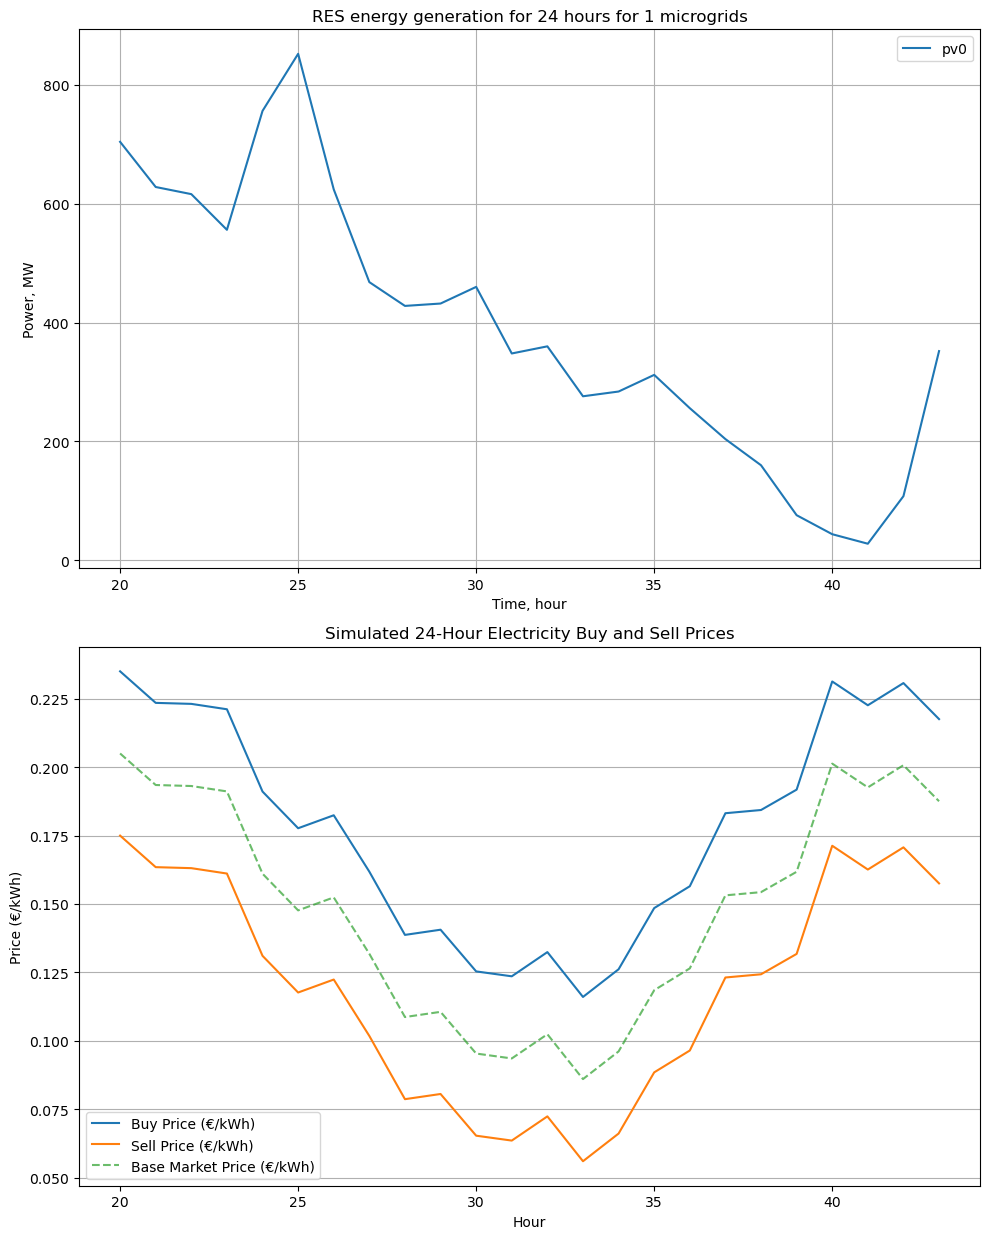

In [45]:
DAYS = 1
H=24
N=3
M=1
start = 20

# Set seed for reproducibility
np.random.seed(42)

hours = np.arange(start, start + H)
base_price = 0.15
amplitude = 0.10

noise = np.random.normal(0, 0.01, size=24*DAYS)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.03
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# Load CSV data
pv_energy = '2023_photovoltaic_total_at.csv'  # Replace with your actual file path
wt_energy = '2023_windpower_total_at.csv'  # Replace with your actual file path

pv = pd.read_csv(pv_energy, delimiter=';')
wt = pd.read_csv(wt_energy, delimiter=';')

pv_arr = pv['Power (MW)'].to_numpy()
wt_arr = wt['Power (MW)'].to_numpy()


q = create_energy_set(start, M, H*DAYS, pv_arr, wt_arr)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

axs[0].set_title(f'RES energy generation for {H*DAYS} hours for {M} microgrids')
for m in range(M): 
    axs[0].plot(np.arange(start, start+H*DAYS), q[m,:], label=f"pv{m}")
axs[0].legend()
axs[0].set_xlabel('Time, hour')
axs[0].set_ylabel('Power, MW')
axs[0].grid(True)
# First subplot: Buy and Sell Prices
axs[1].plot(hours, c, label='Buy Price (€/kWh)')
axs[1].plot(hours, p, label='Sell Price (€/kWh)')
axs[1].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[1].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Price (€/kWh)")
axs[1].grid(axis='y')
axs[1].legend()

plt.tight_layout()
plt.savefig("Decentralised with data environmental parameters", dpi=300)
plt.show()

In [40]:
fleet = EVFleet(xlsx_path='EV_UsageProfile.xlsx', num_vehicles=N*M)
results = fleet.simulate_multiple_days(num_days=1)

L_usage = np.zeros((M,N,DAYS+1,4), dtype='int')
for row in results:
    L_usage[row['EV'] // N, row['EV'] % N, row['Day']-1, 0] = int(row['Initial SoC'])
    L_usage[row['EV'] // N, row['EV'] % N, row['Day']-1, 1] = int(row['Goal (kWh)'])
    L_usage[row['EV'] // N, row['EV'] % N, row['Day']-1, 2] = int(row['Arrival (h)'])
    L_usage[row['EV'] // N, row['EV'] % N, row['Day']-1, 3] = int(row['Departure (h)']) + 24 if int(row['Departure (h)']) + 24 < 34 else 33

    print(row['EV'] // N, row['EV'] % N, L_usage[row['EV'] // N, row['EV'] % N, row['Day']-1, :])

0 0 [1061 8000   16   30]
0 1 [1850 8000   14   31]
0 2 [1280 8000   13   30]


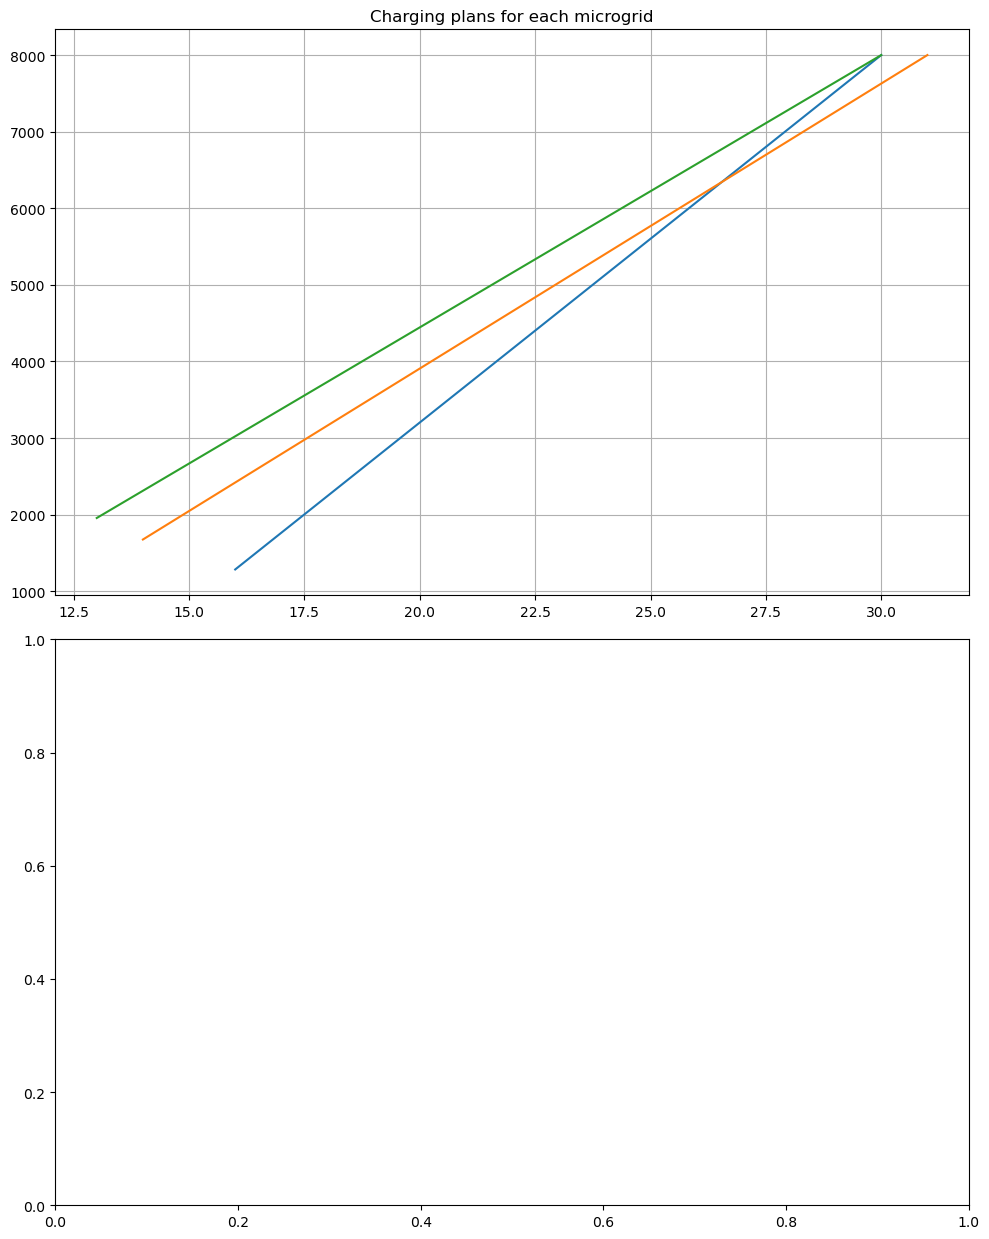

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10,12.5))
for m in range(M):
    for n in range(N):
        L_init, L_target, L_arrival, L_dep = L_usage[m,n,0,:]
        y = [L_init, L_target]
        x = [L_arrival, L_dep]
        axs[m].plot(x,y)
        axs[m].grid(True)
axs[0].set_title("Charging plans for each microgrid");
plt.tight_layout()
plt.savefig("Charging plans for each microgrid", dpi=300)
plt.show()

L_target = L_usage[:,:,0,1]
L_init = L_usage[:,:,0,0]
L_arrival = L_usage[:,:,0,2]
L_depart = L_usage[:,:,0,3]

array([[1284, 1675, 1956]])

In [104]:
# Constants
rho = 1.8 #1.8
gamma = 0.1 #0.1

epsilon = 0.1
c1 = 5
eta = 0.9

# Random seeds for reproducibility
np.random.seed(42)



L_min = np.ones((N, H)) * 0
L_max = np.ones((N, H)) * 10000

d_min = np.zeros((N, H))
d_max = np.ones((N, H)) * 1000

f_min = np.zeros((N, H))
f_max = np.ones((N, H)) * 1000

l_min = np.zeros((N, H))
l_max = np.ones((N, H)) * 1000

m_min = np.zeros((N, H))
m_max = np.ones((N, H)) * 1000

# Initial values
x = np.array([np.zeros(5*H) for _ in range(N)])  # d, f, l, m, L[1:]
lambdas = np.zeros(H)

x_prev = copy.deepcopy(x)
iteration = 0

# Collect data for plotting
d_history = np.array([np.zeros(H) for n in range(N)])
f_history = np.array([np.zeros(H) for n in range(N)])
l_history = np.array([np.zeros(H) for n in range(N)])
m_history = np.array([np.zeros(H) for n in range(N)])
L_history = np.array([np.zeros(H) for n in range(N)])

cost_terms = []
penalty_terms = []

H_n_T_x = np.zeros((N,H))
H_n_T_xi = np.zeros((N,H))
# ADMM loop
while True:
    iteration += 1
    
    final_cost = 0
    for n in range(N):
        # Variables
        constraints = []
        xi = cp.Variable(5*H)
        d = xi[:H]
        f = xi[H:2*H]
        l = xi[2*H:3*H]
        m = xi[3*H:4*H]
        L = xi[4*H:]

        start_time = L_arrival[0][n]-start
        end_time = L_depart[0][n]-start

        # Objective components
        net_cost = cp.sum(cp.multiply(c, d) / q[0] - cp.multiply(p, f) / q[0])
    
        charge_penalty = cp.sum_squares(L[end_time] - L_target[0][n])
    
        h_n_T_x = -d + f + l - m
        admm_penalty = (rho / 2) *  cp.sum_squares(h_n_T_x  + cp.sum(H_n_T_x,axis=0) - H_n_T_x[n] - q[0] - 1/rho * lambdas)

        admm_update = 11/2 *cp.sum_squares(xi - x_prev[n]) # 5.5

        objective = cp.Minimize(c1*net_cost + charge_penalty + admm_penalty +  admm_update)

        # Constraints
        constraints += [
            L >= L_min[n],
            L <= L_max[n],
            d >= d_min[n],
            d <= d_max[n],
            f >= f_min[n],
            f <= f_max[n],
            l >= l_min[n],
            l <= l_max[n],
            m >= m_min[n],
            m <= m_max[n]
        ]
        
        constraints += [
             L[L_arrival[0,n]-start] == L_init[0][n] + l[L_arrival[0,n]-start] - m[L_arrival[0,n]-start]
        ]
        for h in range(1, H):
            constraints += [
                L[h] == L[h-1] + l[h] - m[h],
                cp.abs(l[h-1] - l[h]) <= 500,
                cp.abs(m[h-1] - m[h]) <= 500,
                cp.abs(d[h-1] - d[h]) <= 500,
                cp.abs(f[h-1] - f[h]) <= 500,
            ]
            
        for h in range(start, start + H):
                if h >= L_depart[0,n]:
                    constraints += [
                        l[h-start] == 0,
                        m[h-start] == 0,
                        d[h-start] == 0
                    ]
                if h <= L_arrival[0,n]:
                    constraints += [
                        l[h-start] == 0,
                        m[h-start] == 0,
                        d[h-start] == 0
                    ]                    
            

        # Solve
        prob = cp.Problem(objective, constraints)
        solvers = [cp.SCS, cp.ECOS, cp.CLARABEL, cp.OSQP, cp.GUROBI]  
        solution_found = False
    
        for solver in solvers:
            try:
                prob.solve(solver=solver)
                if prob.status in ["optimal"]:
                    solution_found = True
                    break
                else:
                    print(f"Solver {solver} failed. Trying next...")
            except Exception as e:
                print(f"Solver {solver} encountered an error: {e}")
    
        if not solution_found:
            print("No valid solution found with available solvers.")
            
        """
        print(f"######### Parameters for Agent: {n} ##########")
        print(f"Net cost: {net_cost.value}")
        print(f"Charge penalty: {charge_penalty.value}")
        print(f"Lambda penalty: {admm_penalty.value}")
        print(f"Update penalty: {admm_update.value}")
        print(f"Objective value: {objective.value}")
        print(f"############################################")
        print(f" ")
        """
        # Save values
        x[n] = copy.deepcopy(xi.value)
        H_n_T_xi[n] = copy.deepcopy(h_n_T_x.value)

        # Collect data for plotting
        d_history[n] = copy.deepcopy(d.value)
        f_history[n] = copy.deepcopy(f.value)
        l_history[n] = copy.deepcopy(l.value)
        m_history[n] = copy.deepcopy(m.value)
        L_history[n] = copy.deepcopy(L.value)

        final_cost += net_cost.value + charge_penalty.value
    
    H_n_T_x = copy.deepcopy(H_n_T_xi)
    
    lambdas -= gamma * rho * (np.sum(H_n_T_x, axis=0) - q[0])
    #gamma *=0.9
    print("--------------------------------------------")
    print(f"ITERATION: {iteration}, difference: {np.linalg.norm(x-x_prev)}, lambda {np.linalg.norm(np.sum(H_n_T_x, axis=0) - q)}")
    print("--------------------------------------------")
    print(f" ")
    
    if np.linalg.norm(x-x_prev) <= epsilon:
        break
    print(f"Charge penalty: {charge_penalty.value}")
    x_prev = copy.deepcopy(x)
    
print(final_cost)

--------------------------------------------
ITERATION: 1, difference: 6300.452532558444, lambda 2425.816140071332
--------------------------------------------
 
Charge penalty: 59922770.747224875
--------------------------------------------
ITERATION: 2, difference: 1215.1709748087928, lambda 1293.0830004571014
--------------------------------------------
 
Charge penalty: 56243290.29961891
--------------------------------------------
ITERATION: 3, difference: 1045.5617070314613, lambda 683.782489421642
--------------------------------------------
 
Charge penalty: 52857767.83026639
--------------------------------------------
ITERATION: 4, difference: 931.898646451524, lambda 497.5957735430594
--------------------------------------------
 
Charge penalty: 49770403.589048326
--------------------------------------------
ITERATION: 5, difference: 860.357445296723, lambda 422.6050239626411
--------------------------------------------
 
Charge penalty: 47195931.60494895
------------------

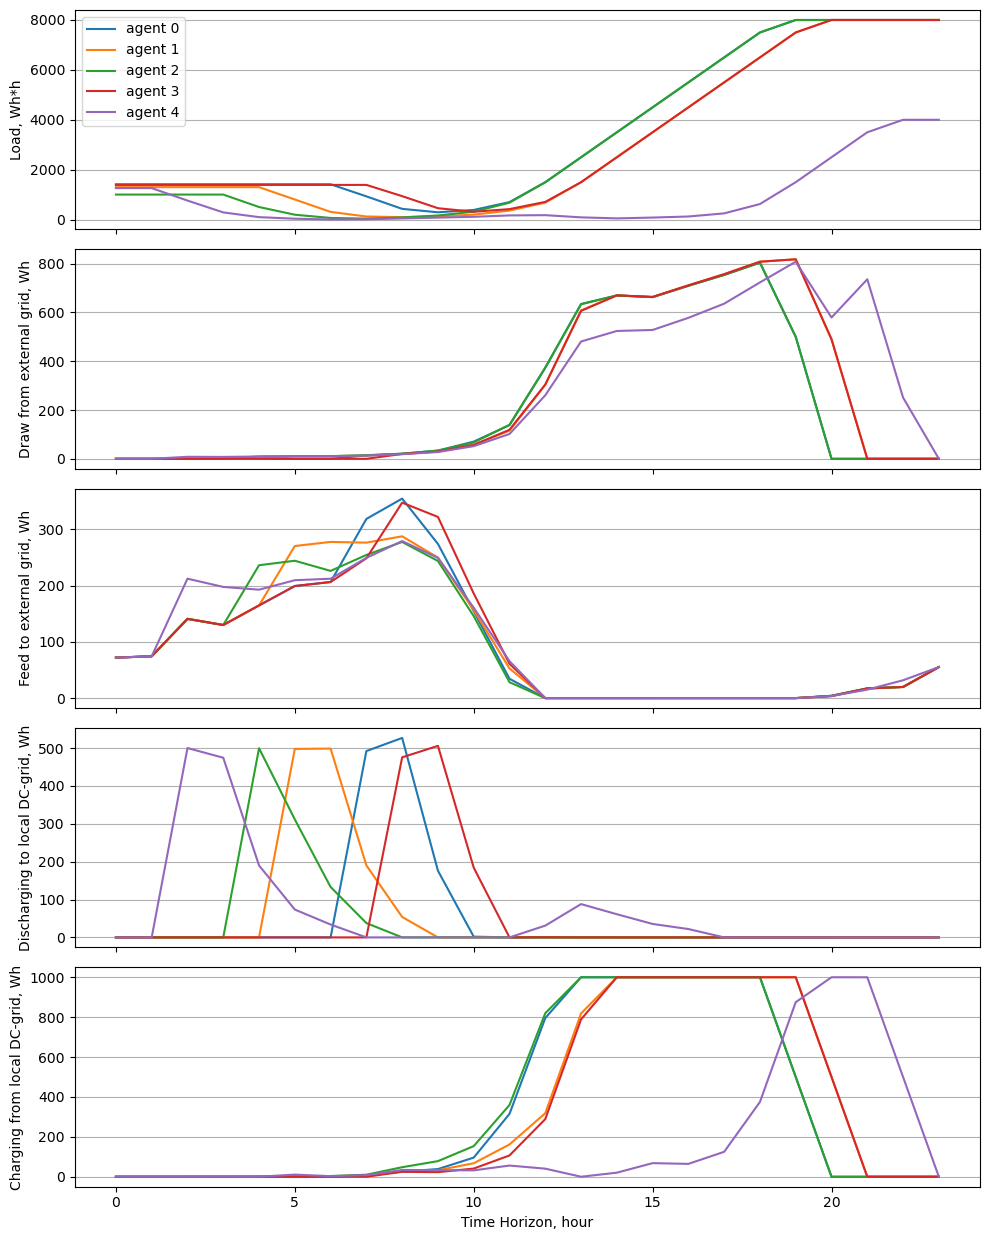

In [132]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)

for n in range(N):
    #axes[0].plot(np.full(H,L_target[n]))
    axes[0].plot(L_history[n], label =f'agent {n}')
    axes[0].grid(axis='y')
    axes[0].legend()
    axes[0].set_ylabel("Load, Wh*h")

for n in range(N):
    axes[1].plot(d_history[n])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")

for n in range(N):
    axes[2].plot(f_history[n])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
    
for n in range(N):
    axes[3].plot(m_history[n])
    axes[3].grid(axis='y')
    axes[3].set_ylabel("Discharging to local DC-grid, Wh")
    
for n in range(N):
    axes[4].plot(l_history[n])
    axes[4].grid(axis='y')
    axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Decentralised framework with data", dpi=300)
plt.show()

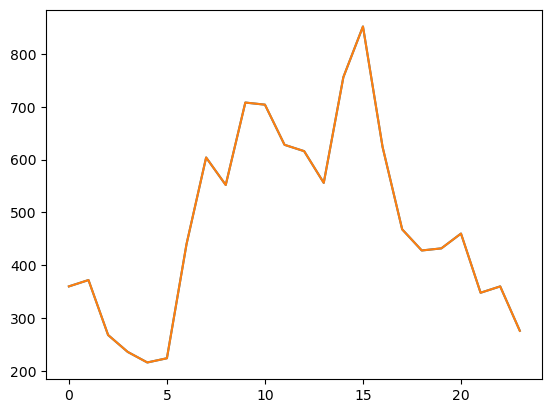

In [134]:
plt.plot(-np.sum(d_history,axis=0)+np.sum(f_history,axis=0)+np.sum(l_history,axis=0)-np.sum(m_history,axis=0))
plt.plot(q[0])
#print(np.mean(np.sum(H_n_T_x,axis=0)-q))
#print((np.sum(H_n_T_x,axis=0)-q).T @ (np.sum(H_n_T_x,axis=0)-q))
#print(cp.sum_squares(np.sum(H_n_T_x,axis=0)-q).value)

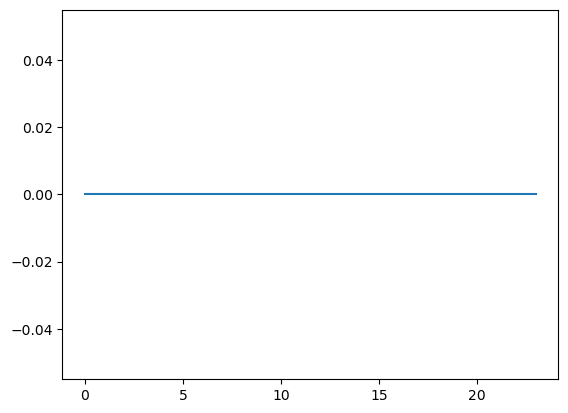

In [61]:
plt.plot(np.sum(l_history,axis=0)-np.sum(m_history,axis=0))

In [63]:
lambdas

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [136]:
total_cost = 0

cost = np.sum(c * d_history / q[0] - p * f_history / q[0]) #+ (L_target - L_history[:,-1]).T@(L_target - L_history[:,-1])
print(cost)


4.4284632299475195


In [158]:
for n in range(N):
    print(f"Error between target and real load of {1+n} agent is {100 * (L_target[0][n] - L_history[n][L_depart[0][n]-start])/L_target[0][n]:.2f}%")
    

Error between target and real load of 1 agent is 0.01%
Error between target and real load of 2 agent is 0.01%
Error between target and real load of 3 agent is 0.02%
Error between target and real load of 4 agent is 0.01%
Error between target and real load of 5 agent is 0.00%


In [31]:
np.sum(c * np.sum(d_history,axis=0)/q - p * np.sum(f_history,axis=0)/q) + (L_target - L_history[:,-1]).T@(L_target - L_history[:,-1])

9.575280327606468

In [46]:
np.sum((c @ np.sum(f_history,axis=0)/q - p @ np.sum(d_history,axis=0))/q)

-122.94848145433234

In [146]:
L_history[n]

array([1416.00000002, 1416.00000002, 1416.00000002, 1416.00000002,
       1416.00000002, 1416.00000002, 1416.00000005,  932.15072555,
        431.17327434,  293.62069061,  387.63551514,  702.73209506,
       1498.21041171, 2498.21638137, 3498.24525534, 4498.29714376,
       5498.37193828, 6498.46885383, 7498.58876574, 7998.80677629,
       7998.8069953 , 7998.80710288, 7998.80717462, 7998.80721049])

In [152]:
n = 1
L_depart

array([[30, 31, 30, 31, 33]])